In [1]:
import os
os.chdir("D:/One Drive/My Portfolio/Face Recognition")

In [6]:
#Wavelets Transformation Function
import pywt
import cv2
import numpy as np
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

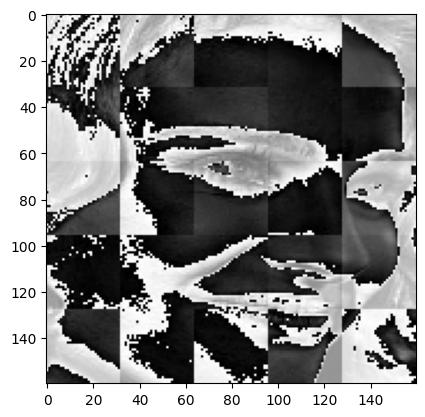

In [7]:
import matplotlib.pyplot as plt
#Example of a wavelets-transformed image
image = cv2.imread("data/processed/Natalie Portman/Natalie Portman19.png")
test_img_har = w2d(image, 'db1', 5)
plt.imshow(test_img_har, cmap='gray')

In [8]:
dataset_dir = 'data/processed'
cleaned_image_dirs = []
for root, dirs, files in os.walk(dataset_dir):
    for d in dirs:
        full_path = os.path.join(root, d)
        cleaned_image_dirs.append(full_path)

In [31]:
celeb_file_name_dict = {}
for img_dir in cleaned_image_dirs:
    celeb_name = os.path.basename(img_dir)
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celeb_file_name_dict[celeb_name] = file_list
celeb_file_name_dict

{'Denzel Washington': ['data/processed\\Denzel Washington\\Denzel Washington1.png',
  'data/processed\\Denzel Washington\\Denzel Washington10.png',
  'data/processed\\Denzel Washington\\Denzel Washington100.png',
  'data/processed\\Denzel Washington\\Denzel Washington11.png',
  'data/processed\\Denzel Washington\\Denzel Washington12.png',
  'data/processed\\Denzel Washington\\Denzel Washington13.png',
  'data/processed\\Denzel Washington\\Denzel Washington14.png',
  'data/processed\\Denzel Washington\\Denzel Washington15.png',
  'data/processed\\Denzel Washington\\Denzel Washington16.png',
  'data/processed\\Denzel Washington\\Denzel Washington17.png',
  'data/processed\\Denzel Washington\\Denzel Washington18.png',
  'data/processed\\Denzel Washington\\Denzel Washington19.png',
  'data/processed\\Denzel Washington\\Denzel Washington2.png',
  'data/processed\\Denzel Washington\\Denzel Washington20.png',
  'data/processed\\Denzel Washington\\Denzel Washington21.png',
  'data/processed\\D

In [34]:
class_dict={}
i = 0
for celeb_name in celeb_file_name_dict.keys():
  class_dict[celeb_name] = i
  i+=1
class_dict

{'Denzel Washington': 0,
 'Kate Winslet': 1,
 'Leonardo DiCaprio': 2,
 'Natalie Portman': 3,
 'Robert Downey Jr': 4}

In [35]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import pandas as pd
import seaborn as sns

In [36]:
#Inputting datasets into X and y
X, y = [],[]
for celeb_name, training_files in celeb_file_name_dict.items():
  for training_image in training_files:
    img = cv2.imread(training_image)
    scalled_raw_img = cv2.resize(img, (32,32))
    img_har = w2d(img, 'db1', 5)
    scalled_img_har = cv2.resize(img_har, (32,32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    X.append(combined_img)
    y.append(class_dict[celeb_name])

In [48]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [49]:
#Create pipline for preprocessing
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8

In [45]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.80      0.63      0.71        19
           2       0.89      0.76      0.82        21
           3       0.83      0.77      0.80        26
           4       0.67      0.94      0.78        17

    accuracy                           0.80       100
   macro avg       0.81      0.81      0.80       100
weighted avg       0.81      0.80      0.80       100



In [43]:
#Hyperparameters to be optimized
param_grid = {
    'svc__C': [1, 10, 100],
    'svc__kernel': ['rbf', 'linear']
}

In [ ]:
# Create a GridSearchCV object
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)
print("Test Accuracy:", grid.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Best Parameters: {'svc__C': 1, 'svc__kernel': 'linear'}
Best Cross-Validation Score: 0.7813291139240507
Test Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.71      0.63      0.67        19
           2       0.75      0.71      0.73        21
           3       0.84      0.81      0.82        26
           4       0.68      0.88      0.77        17

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100



Text(95.72222222222221, 0.5, 'Truth')

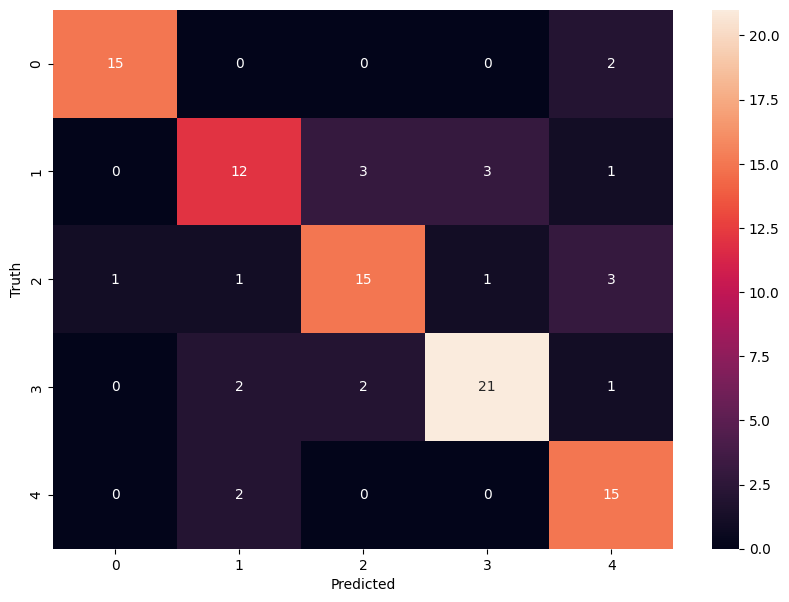

In [53]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')